In [1]:
import gc

import pandas as pd
import numpy as np
import seaborn as sns

from scipy.stats import ttest_ind

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

import matplotlib.pyplot as plt
sns.set()

In [2]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [3]:
def plot_roc_auc(y_true, y_pred, col):
    fpr, tpr, thr = roc_curve(y_true, y_pred)
    descr = f"{col}: {np.round(roc_auc_score(y_true, y_pred), 2)}"
    plt.plot(fpr, tpr, label=descr)
    plt.xlabel("false positive rate")
    plt.ylabel("true positive rate")
    plt.legend(loc=4)
    
def plot_pr(y_true, y_pred):
    prec, rec, thresh = precision_recall_curve(y_true, y_pred)
        
    plt.plot(thresh, prec[:-1], label="precision")
    plt.plot(thresh, rec[:-1], label="recall")
    plt.legend()

# Предыстрория

Чуть чуть поясняющего текста. Если коротко, то мои надежды разобраться со Spark за два дня не оправдались. Но это ок, я не умер.

Я не смог придумать как мне правильно сделать вычисления на spark с теми знаниями, что я успел за два дня о нем получить. У того же GrapgFrames, по какой-то причине почти полностью отсутствует документация. Вначале я чуть приуныл, но потом решил, что не знать чего-то - это нормально. Я выбрал именно это тестовое из трех потому, что меньше всего знал об этой задаче и вообще социальных сетях/графах (помимо кластеризации из коробки игрушечных сетей в R) и мне было интересно разобраться. Так что, я подумал, что лучше отправить что-то, чем ничего, показав, что я могу самостоятельно разобраться в незнакомой мне проблеме и предложить, пусть и наивный, но работающий подход-прототип (ну и еще рассказать о проблемах с которыми столкнулся и как я их решил, вроде ход мысли это важно). **Поэтому итоговый код написан с использованием numpy для вычислений и graph-tool для работы с графом**. Я также изменил датасет, взяв похожую сеть, но поменьше, чтобы у меня была возможность быстрее экспериментировать. Описание можно данных найти [тут](http://snap.stanford.edu/data/ego-Facebook.html). В остальном я следовал заданию. Код вышел слегка топорным, но it works!

P.S. Не думаю, что незнание какого-то инструмента является проблемой. Научиться работать с "взрослыми" данными и проблемами, чуть более серьезными, чем датасеты с каггла, в целом является одной из моих основных целей(и ради который я хотел бы попасть на стажировку). Этому сложно научиться самому в одиночку т.к для себя обычно легче сделать какое-то простое единичное решение на том же pandas. К тому же, с конца отбора и до начала стажировки есть почти месяц, за это время можно вдумчиво прочесть не одну книжку по spark (в то время как сейчас горят дедлайны, сессия и курсовая).

"как решать проблемы computation time"
![окончательное решение по данным](img/modern_problems_require_modern_solutions.jpg)

# Основные сложности

**EDIT**: похоже я сам себе создал проблемы из-за путанницы с тем, как использовать второй круг соседей. Я думал, что вторых соседей нужно использовать для вычисления метрик (что показалось мне логичным, общие друзья друзей показывают насколько пересекаются круги общения ваших друзей -> больше выбор, сила слабых связей вот это все). Однако, похоже есть вариант, что друзей друзей надо было использовать как кандидатов для вычисления метрик для отдельной вершины (к чему я в итоге и пришел). Возможно это обьясняет почему мои метрики на втором круге так плохо сработил :с

Самой большой проблемой оказался подсчет метрик для всех пар. Думаю, догадаться, что считать для всех пар явно плохой путь было частью задания. Для наивного подхода без распараллеливания (по моим скромным подсчетам) потребовалось бы около 12 дней, чтобы осилить $63700^2$ возможных пар и около 1 дня для $4000^2$ маленькой сети. Это очень много. Я спросил совета в слаке ODS, где мне подсказали, что если сеть помещается в память, то все следует считать локально, может даже получится быстрее спарка. Значит, я делал что-то не так. Изначально я использовал библиотеку networkx, но позже переписал код с использованием graph-tool. 

Для того чтобы все посчиталось:
1. я с радостью осознал, что для метрик на первой окрестности, для пар на расстоянии больше двух похожесть будет равна 0, а это значит, что мы можем ограничить число кандидатов для каждой вершины только друзьями друзей. Для метрик на второй окрестности у меня возникла похожая гипотеза, я взял несколько рандомных семплов и посчитал на каком в среднем расстоянии лежат наиболее похожие на них по метрикам (все равно те, что ниже 40 мы отфилтруем). Получилось около 3, так что для вторых соседей я также ограничился расстоянием в 3 от вершины. У этого есть некий здравый смысл: зачем мне рекомендовать кого-то, кого я знаю через 1 друга и еще 3 (вероятно) незнакомых мне людей?
2. я решил пожертвовать памятью, посчитав заранее соседей для всех вершин, избежав необходимости проходить по всем парам несколько раз. Сложил это все в словарь вида {айди вершины: список соседей}. Этой информации достаточно для вычисления всех метрик основанных на локальной информации. Это также облегчило создание единого стандарта для метрик. Чтобы добавить новую метрику, достаточно определить функцию, которая принимает этот словарик и пару вершин, а потом передать список метрик в функцию, которая вытаскивает фичи.

В итоге вычисление 3 метрик для 1305081 пар (~8% от всех возможных в графе на 4к) и их запись в csv заняло 16 минут. Для большого графа не посчитал, это заняло бы слишком много времени, хотя явно меньше изначальных 12 дней :) Я заметил, что процесс быстро замедлялся к концу, вероятно из-за того, что я сразу по строкам записывал в файл (наверное оптимальнее записывать по чанкам или в конце за раз).

![вжух](img/full_network.png)

# Где смотреть код

1. [extract_features.py](https://github.com/Howuhh/link_pred/blob/master/extract_features.py) - вычисление метрик
2. [features.py](https://github.com/Howuhh/link_pred/blob/master/linkpred/features.py) - функции для вычисления метрик
3. [metrics.py](https://github.com/Howuhh/link_pred/blob/master/linkpred/metrics.py) - сами метрики

# Оценка модели & данных

Оценивать метрики я буду на данных посчитаных для первого круга соседей, потому что для маленькой сети это вышло оптимальнее по качеству модели, чем с использованием второго круга, да и нагляднее. Т.к. в задание входило посчитать CN и AA для второго круга, я посчитал и их, датасет можно найти в [link_pred/data/](https://github.com/Howuhh/link_pred/tree/master/data). Я также добавил новую метрику основанную на [resource allocation](http://image.sciencenet.cn/olddata/kexue.com.cn/upload/blog/file/2009/10/2009102822251329127.pdf). Таргет здесь равен 1, если связь существует в тестовом графе и 0 если нет. Связи с трейн/тест графах не пересекаются. 

In [4]:
df = pd.read_csv("data/fc_features_first.csv", 
                 names=["from", "to", "CN", "AA", "RA", "target"])

In [6]:
print(df.shape)
df.head()

(161320, 6)


,from,to,CN,AA,RA,target
0,0.0,82.0,28.0,9.159,1.404,0.0
1,0.0,313.0,29.0,9.034,1.277,0.0
2,0.0,342.0,30.0,8.939,1.148,0.0
3,0.0,236.0,30.0,9.186,1.225,0.0
4,0.0,325.0,31.0,8.900,1.042,0.0


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
from,161320.0,2017.927845,1165.052442,0.0,1009.000,2018.000,3026.000,4038.000
to,161320.0,1996.647099,1166.772504,0.0,992.000,1983.000,3034.000,4038.000
CN,161320.0,24.208331,32.434074,0.0,4.000,11.000,30.000,233.000
AA,161320.0,5.555784,6.662385,0.0,1.008,3.017,7.377,50.133
RA,161320.0,0.366429,0.317920,0.0,0.102,0.296,0.565,6.361
target,161320.0,0.050025,0.217997,0.0,0.000,0.000,0.000,1.000


## Simple EDA

На графиках можно увидеть, что разница между классами есть, хотя на графиках для CN vs AA она менее явная т.к они почти идеально коррелируют.

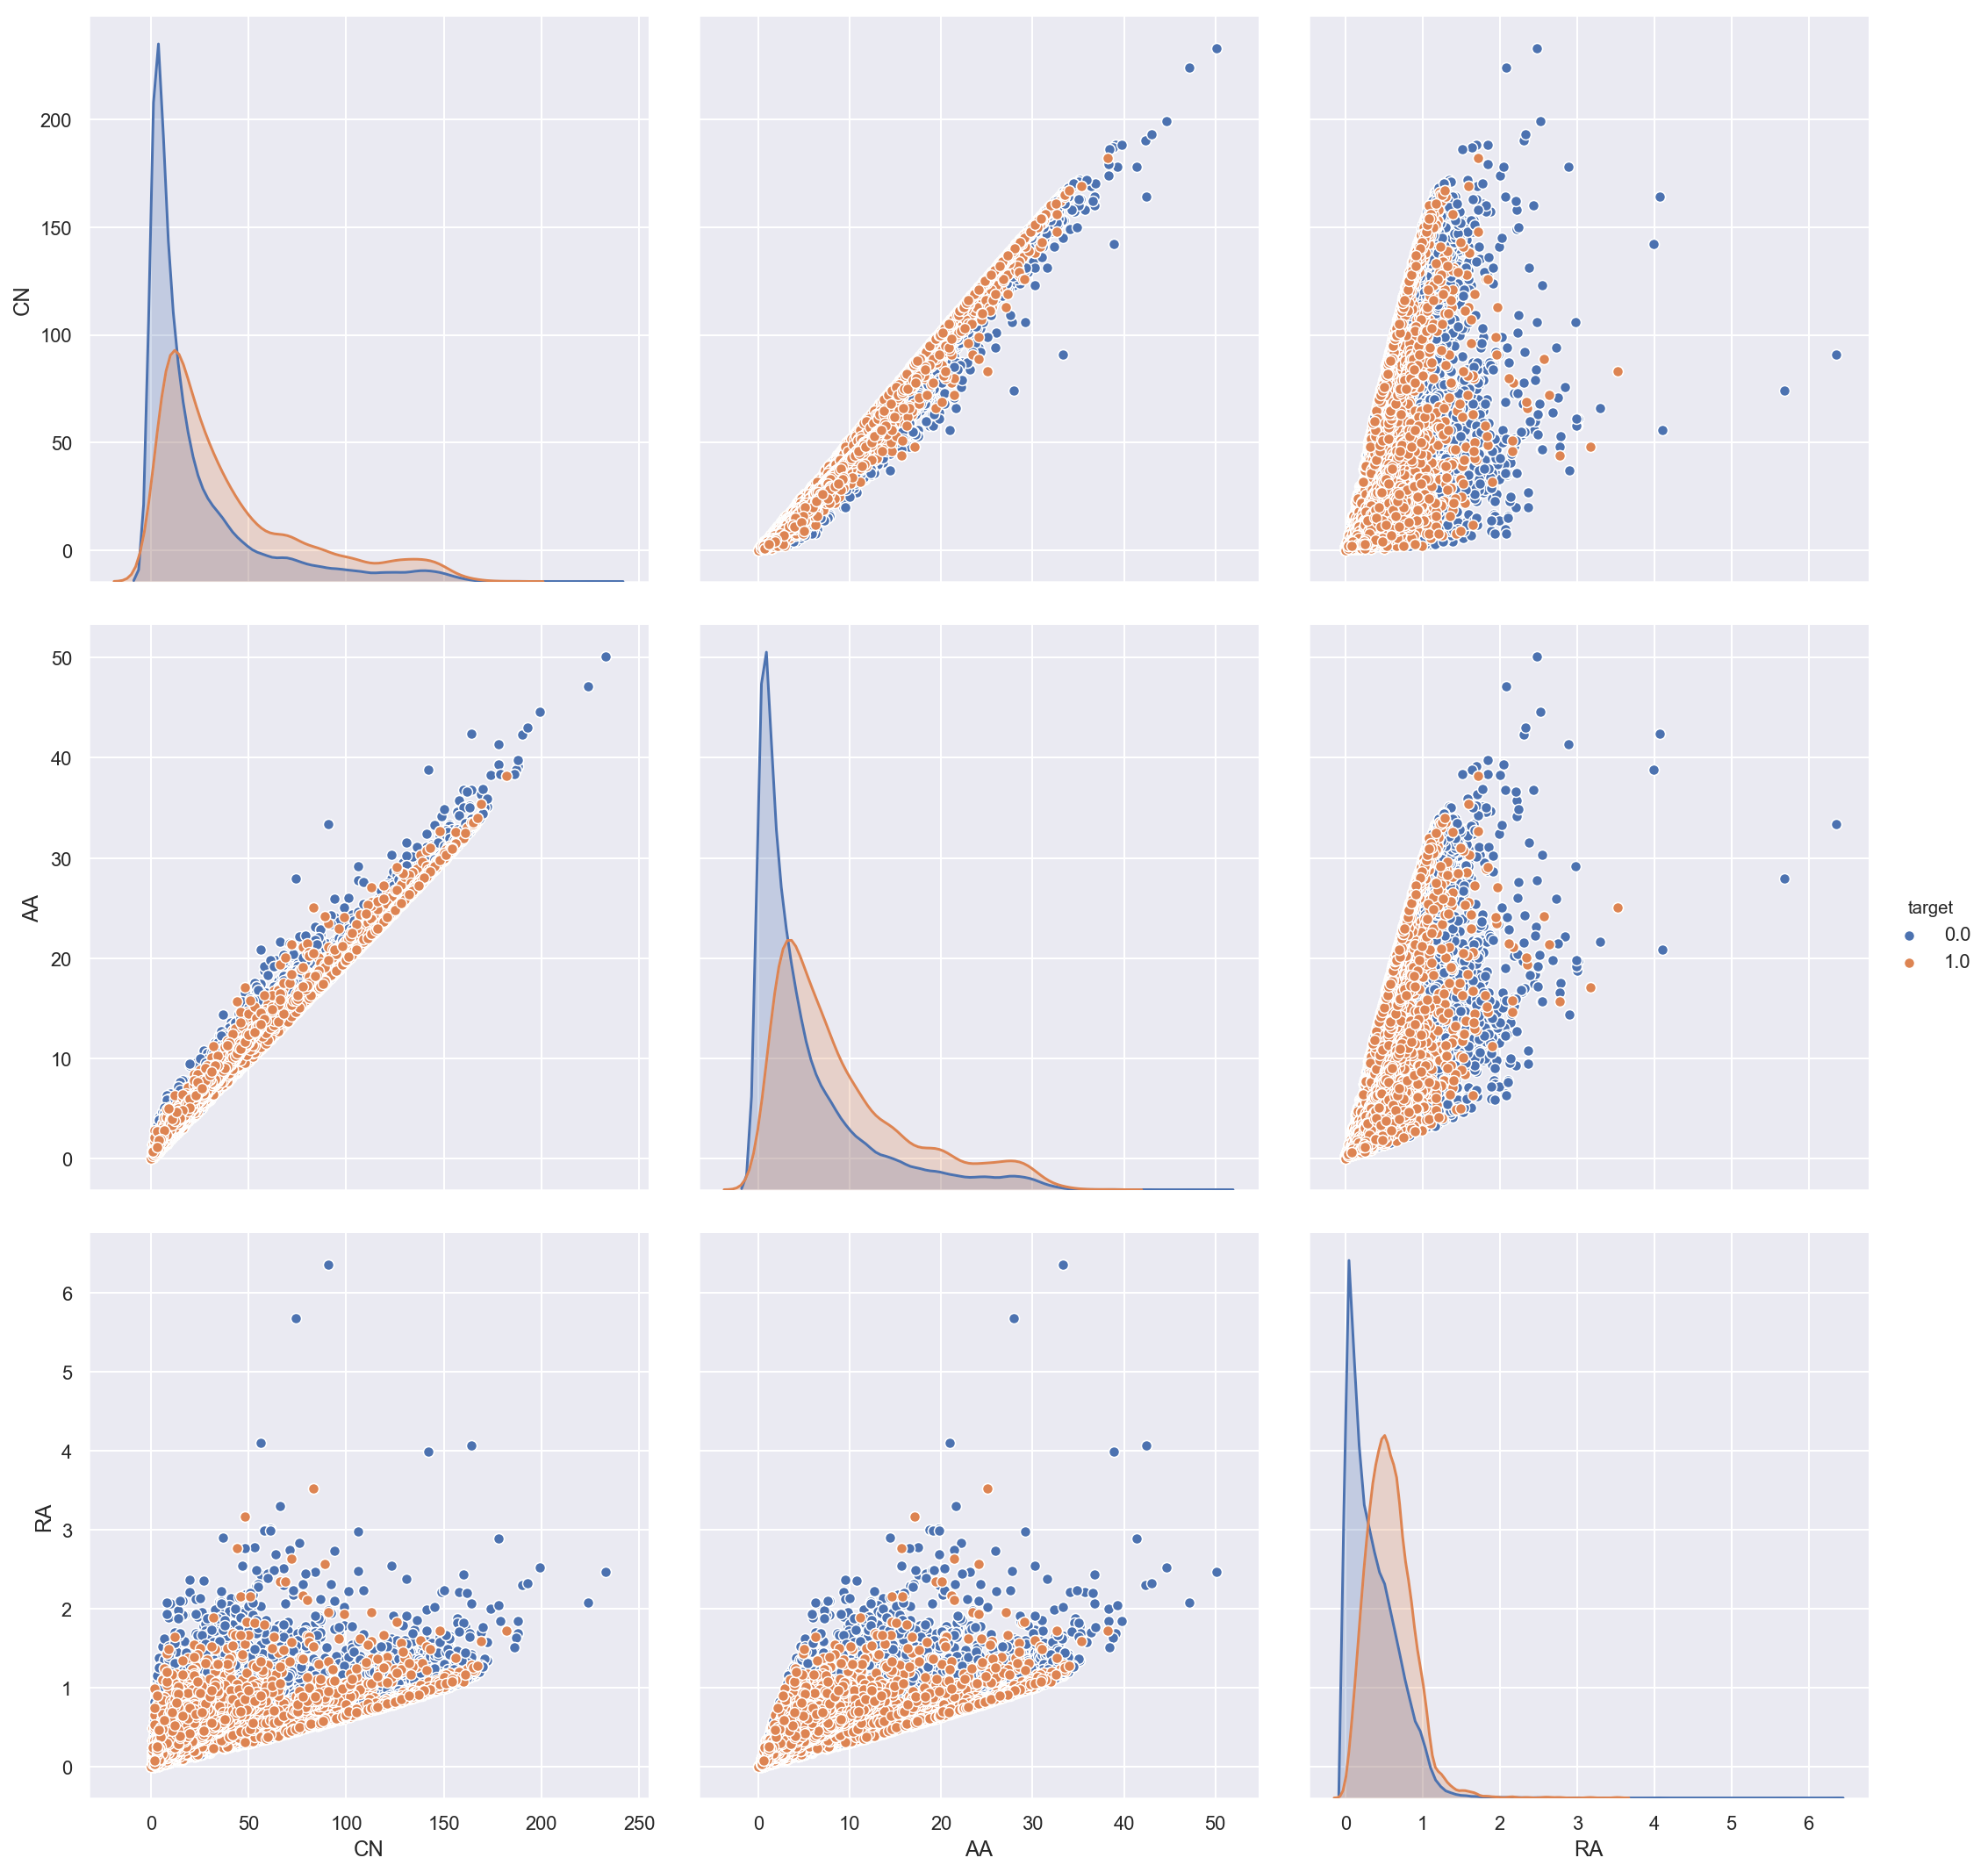

In [32]:
sns.pairplot(df, vars=["CN", "AA", "RA"], hue="target", height=5);

Здесь более наглядно, разница в средних для классов по метрикам.

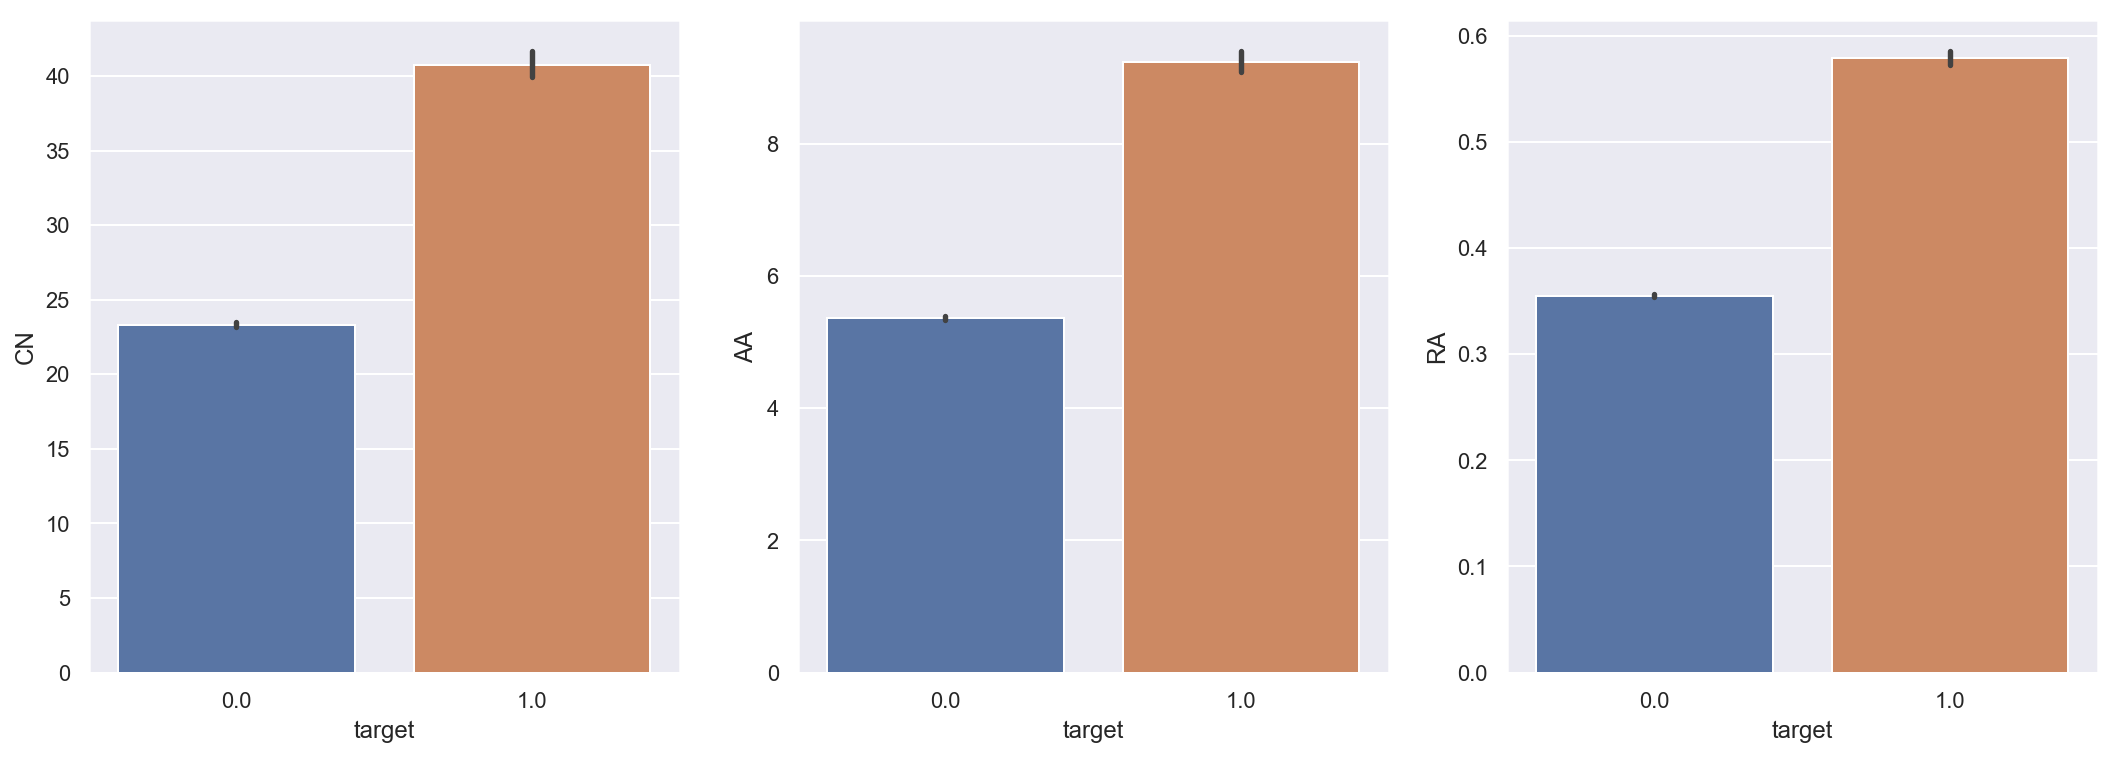

In [34]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

for i, col in enumerate(["CN", "AA", "RA"]):
    sns.barplot("target", col, data=df, ax=ax[i])

И еще раз, но уже с распределениями. Видно, что существует много выбросов, однако разница в медиание похоже значима.

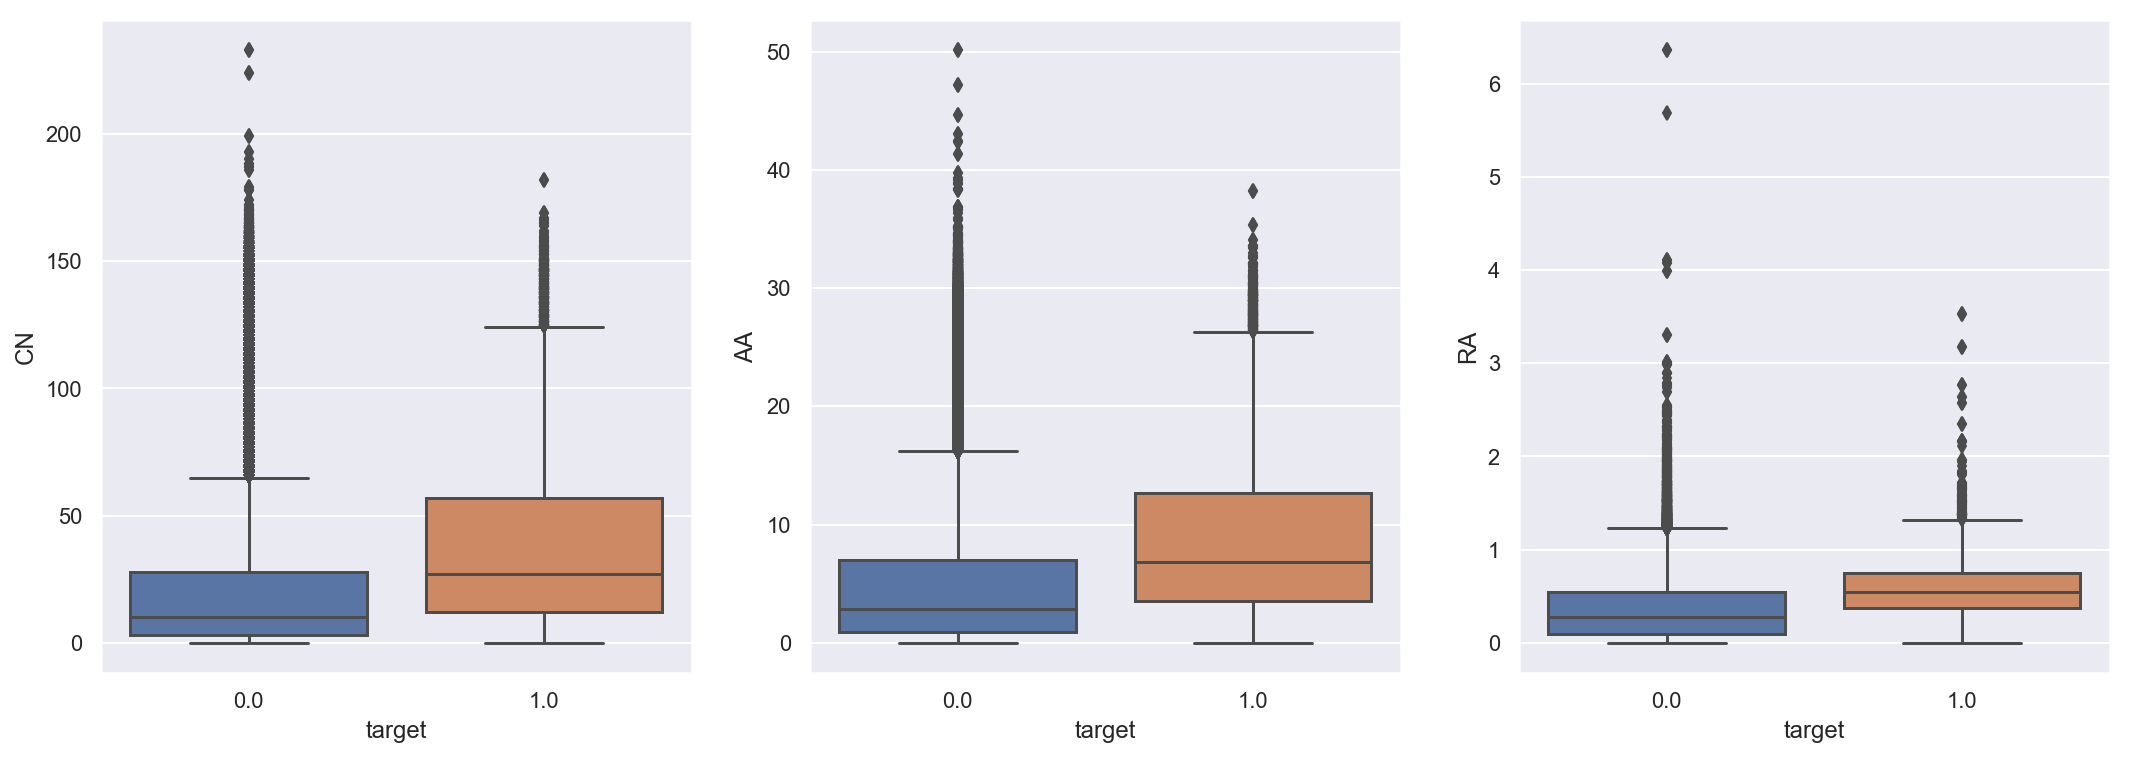

In [37]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

for i, col in enumerate(["CN", "AA", "RA"]):
    sns.boxplot("target", col, data=df, ax=ax[i])

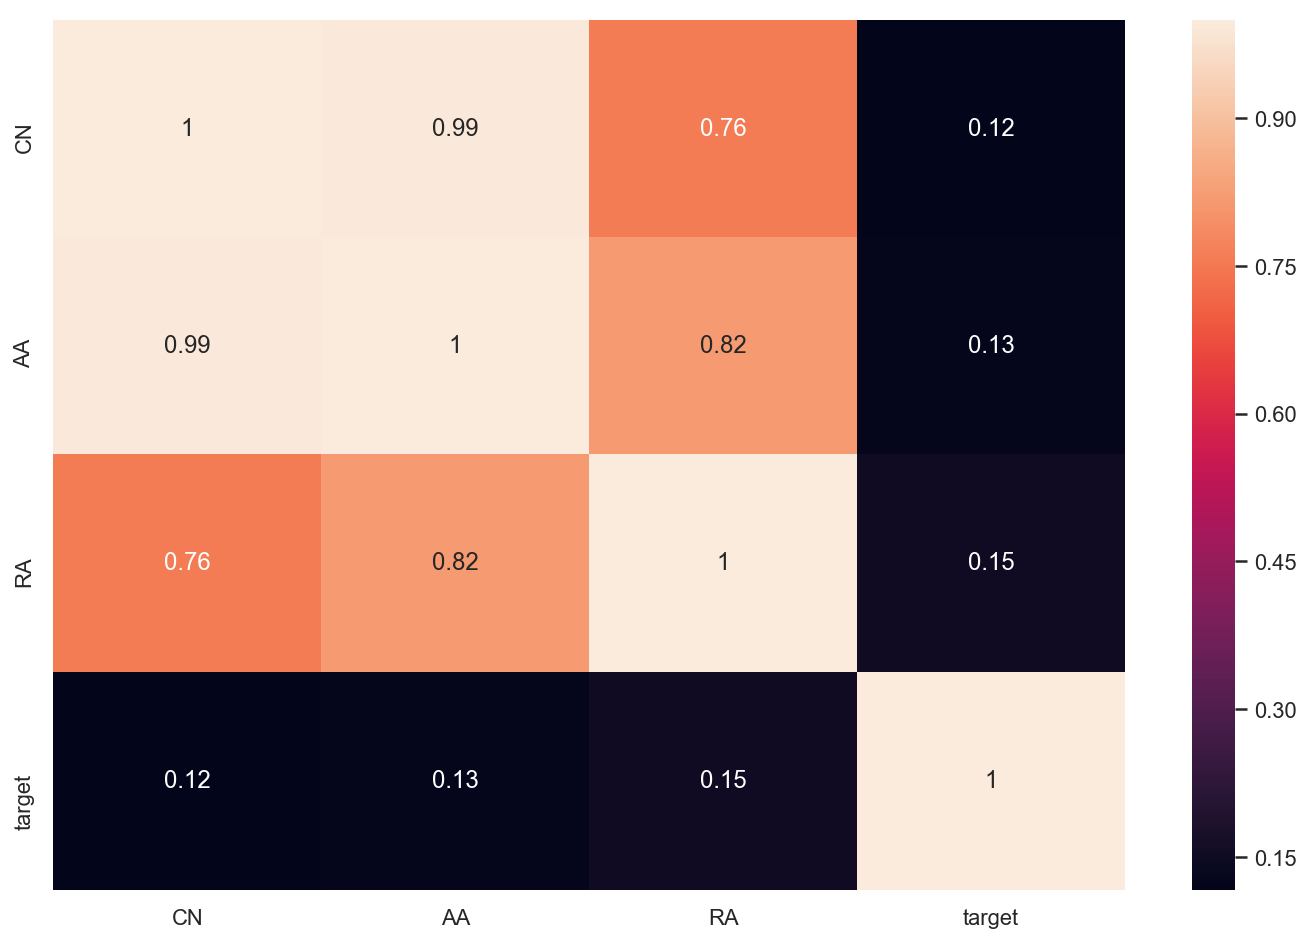

In [89]:
cor = df.loc[:, "CN":"target"].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(cor, annot=True);

In [38]:
df.groupby("target")["CN", "AA", "RA"].agg([np.mean, np.median])

CN               AA               RA       
             mean median      mean median      mean median
target                                                    
0.0     23.337716   10.0  5.362034  2.850  0.355223  0.279
1.0     40.741388   27.0  9.235116  6.802  0.579242  0.549

Проверим значимость различия средних с помощью t-test'a. Все три средних значения метрики значимо различны для двух классов.

In [9]:
df_neg = df.query("target == 0")
df_pos = df.query("target == 1")

for col in ["CN", "AA", "RA"]:
    _, p = ttest_ind(df_neg["CN"], df_pos["CN"])
    print(f"Significant difference for {col}: {p < 0.05}")

Significant difference for CN: True
Significant difference for AA: True
Significant difference for RA: True


## Baseline

Ради интереса я чуть чуть потюнил модель и попробовал разные штуки, но оказалось, что на качество это особо не влияет, поэтому для анализа оставлю простой бейзлайн. Больше всего на качество повлиял PCA на две компоненты (из-за сильной корреляции CN и AA).

In [46]:
df_train = df.loc[:, "CN":"target"]
X_train, X_test, y_train, y_test = train_test_split(df_train.drop(["target"], axis=1), 
                                                    df_train.target, test_size=0.2,
                                                   random_state=42)

In [47]:
base = LogisticRegression(solver="lbfgs", class_weight="balanced")
cv = StratifiedKFold(n_splits=5, random_state=42)

Если ничего не знать о соотношении классов такое качество может показаться даже хорошим (не 0.5 же!), но далее станет понятно, что в таком виде данная модель бесполезна (но все поправимо, но это не точно).

In [48]:
base_score = cross_val_score(base, X_train, y_train, cv=cv, scoring="roc_auc")
base_score.mean()

0.7201697894168626

## Оценка модели

Нарисуем кривые roc_auc на графике отдельно для каждой метрики. RA показывает себя лучше других (насколько по такой модели вообще возможно судить о качестве). Эта метрика была предложена в 2009 году и по бенчмаркам авторов показала себя лучше 8 остальных частых метрик основанных на соседстве. Однако в новых пейперах ее почему-то не используют. 


У такого результата может быть несколько обьяснений: вероятно, связь нелинейная, а RA изначально была предложена как раз для выявления нелинейной связи в другой области (transportation capacity and connectivity of each airport). В этой сети также есть вершины с большим количеством связей. RA гораздо сильнее штрафует за общих соседей с большим количеством связей, давая им меньший вес. 

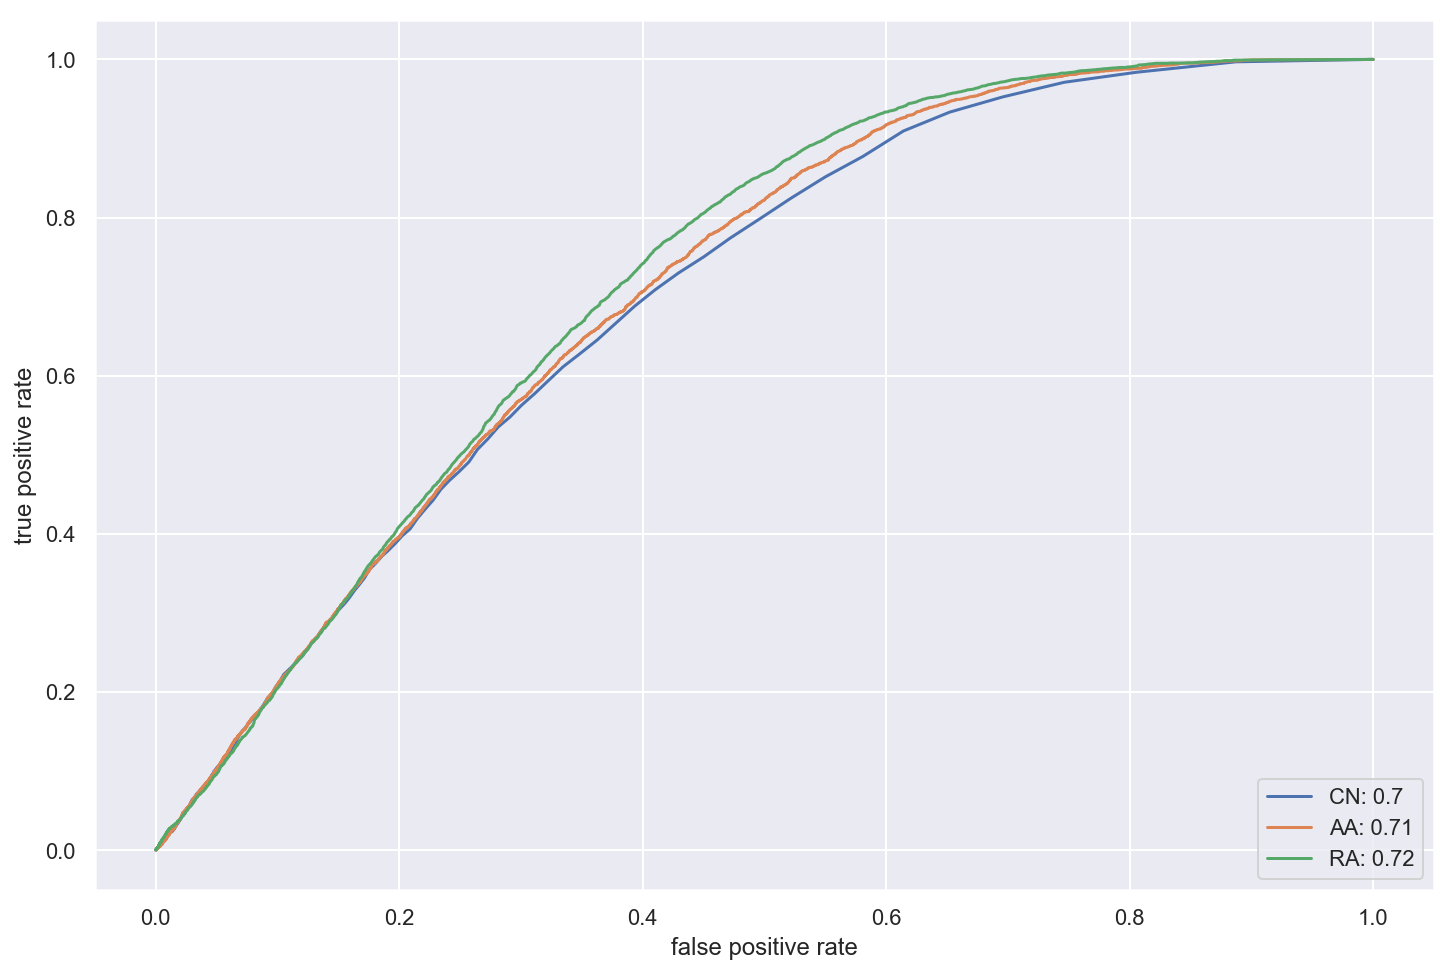

In [270]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(["CN", "AA", "RA"]):
    X_train_drop = X_train[col].values.reshape(-1, 1)
    
    model = LogisticRegression(solver="lbfgs", class_weight="balanced")
    model.fit(X_train_drop, y_train)
    y_pred = model.predict_proba(X_train_drop)[:, 1]
    
    plot_roc_auc(y_train, y_pred, col)

Качество модели не изменится, если подсчитать его по всем возможным парам признаков, поэтому я не показываю здесь график для этого случая.

Посмотрев на график выше можно понять, что что-то идет не так и модель делает слишком много false positive ошибок. Следующим этапом должен быть выбор порога, поэтому посмотрим как изменяется кривые точности и полноты в зависимости от различных значений порога.

In [49]:
base.fit(X_train, y_train)
y_pred = base.predict_proba(X_train)[:, 1]

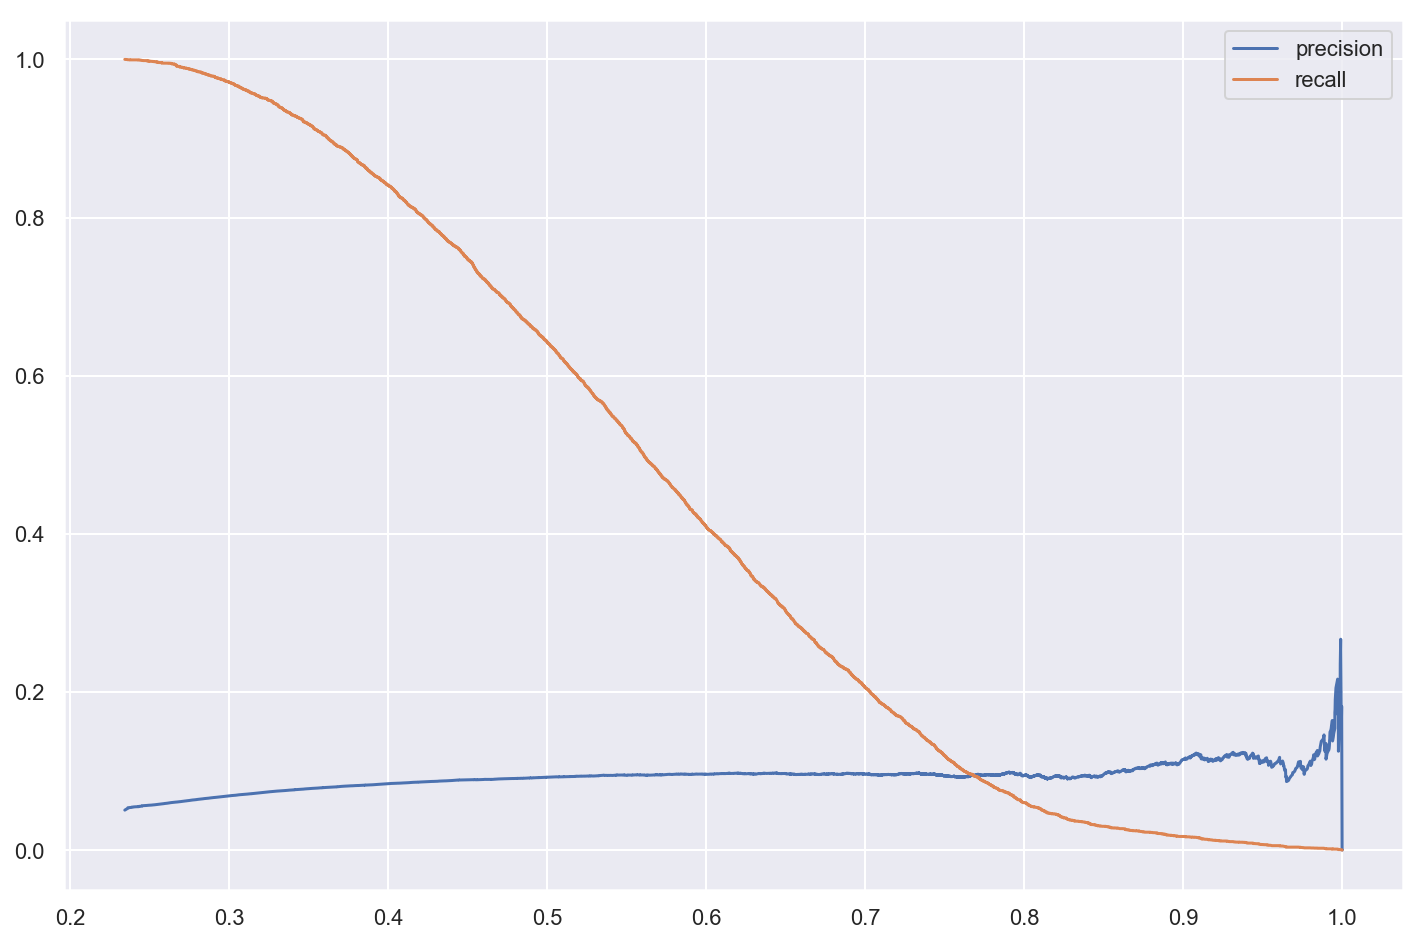

In [50]:
plt.figure(figsize=(12, 8))
plot_pr(y_train, y_pred)

Здесь становиться видна проблема. Если не ставить в модели class_weight="balanced", модель вообще не будет предсказывать положительный класс, а если поставить, то модель начинает рисковать и завышать вероятности тем самым делая много FP, тогда как точность почти при всех порогах не поднимается выше 10%.  При осторожном пороге в 0.5 точность получается 9%, что для рекомендаций бесполезно. Мы будем рекомендовать слишком много нерелевантных друзей. То есть весь результат roc_auc это все еще предсказание только отрицательного класса.

In [275]:
print(classification_report(y_train, (y_pred > 0.5).astype(np.int)))

              precision    recall  f1-score   support

         0.0       0.97      0.67      0.79    122599
         1.0       0.09      0.64      0.16      6457

    accuracy                           0.67    129056
   macro avg       0.53      0.65      0.48    129056
weighted avg       0.93      0.67      0.76    129056



# Фильтрация по квантилю

Возможно наши признаки все же не работают? На графике с боксплотами можно было увидеть много выбросов, возможно модель подгоняется под них минимизируя ошибку? Попробуем отфильтровать.

In [5]:
aa_q = df["AA"].quantile(0.85)
cn_q = df["CN"].quantile(0.85)
ra_q = df["RA"].quantile(0.95)

In [6]:
df_filt = df.query("AA < @aa_q and CN < @cn_q and RA < @ra_q")

Видно, что разница между классами существенна, то есть признаки все же работают. 

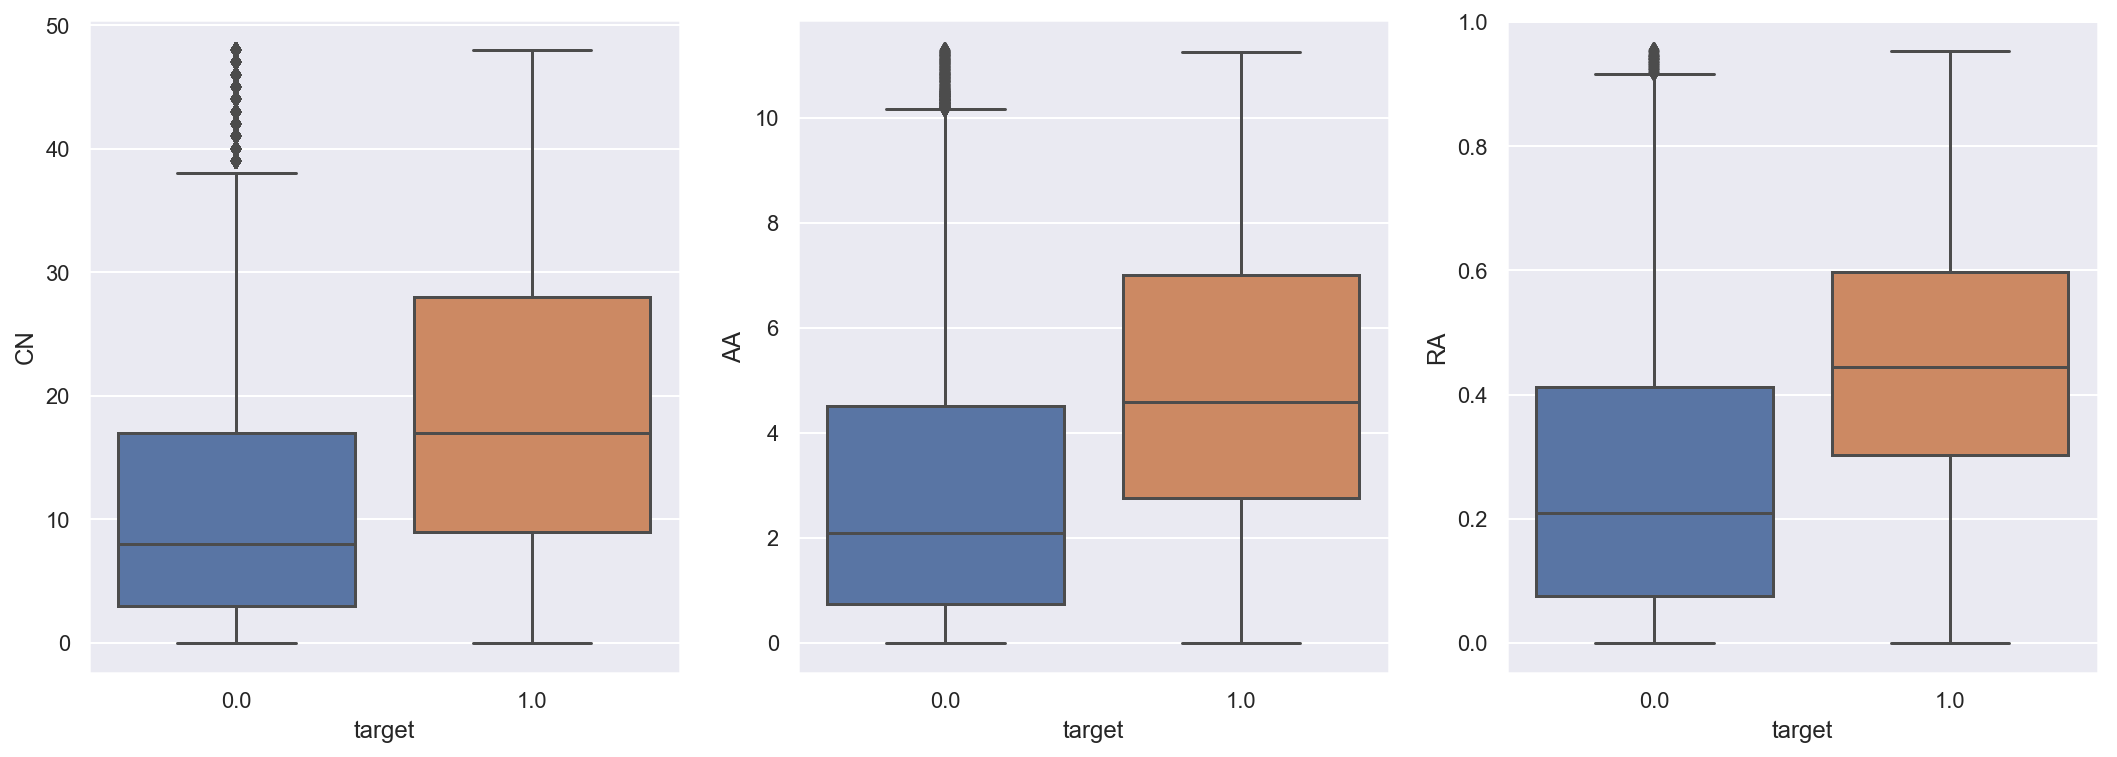

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

for i, col in enumerate(["CN", "AA", "RA"]):
    sns.boxplot("target", col, data=df_filt, ax=ax[i])

Попробуем обучить модель на этих данных:

In [20]:
model_filt = LogisticRegression(solver="lbfgs", random_state=42, class_weight="balanced")

In [21]:
df_filt_train = df_filt.loc[:, "CN":"target"]
X_train_filt, X_test_filt, y_train, y_test = train_test_split(df_filt_train.drop(["target"], axis=1), 
                                                    df_filt_train.target, test_size=0.2,
                                                   random_state=42)

In [22]:
model_filt.fit(X_train_filt, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
y_pred_filt = model_filt.predict_proba(X_train_filt)[:, 1]

In [27]:
roc_auc_score(y_train, y_pred_filt)

0.7449039244732165

In [25]:
print(classification_report(y_train, (y_pred_filt > 0.5).astype(np.int)))

              precision    recall  f1-score   support

         0.0       0.98      0.68      0.80    103030
         1.0       0.08      0.67      0.15      4408

    accuracy                           0.68    107438
   macro avg       0.53      0.68      0.48    107438
weighted avg       0.94      0.68      0.78    107438



Качественного улучшения не произошло. Думаю проблема либо в нелинейности связи, либо в дисбалансе классов. 

# Down-sampling

Ради эксперимента можно попробовать простой способ и слегка уравнять классы сэмплированием без возвращения.

In [37]:
from sklearn.utils import resample

In [38]:
df_neg = df_filt[df_filt.target==0]
df_pos = df_filt[df_filt.target==1]
 
df_downsampled = resample(df_neg, 
                         replace=False,    
                         n_samples=df_pos.shape[0],    
                         random_state=42) 
df_downsampled = pd.concat([df_downsampled, df_pos])

In [39]:
df_downsampled = df_downsampled.loc[:, "CN":"target"]
X_train_down, X_test_down, y_train_down, y_test_down = train_test_split(df_downsampled.drop(["target"], axis=1), 
                                                    df_downsampled.target, test_size=0.2,
                                                   random_state=42)

In [40]:
model_down = LogisticRegression(solver="lbfgs", class_weight="balanced")
model_down.fit(X_train_down, y_train_down)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [41]:
y_pred_down = model_down.predict_proba(X_train_down)[:, 1]

In [42]:
print(classification_report(y_train_down, (y_pred_down > 0.5).astype(int)) )

              precision    recall  f1-score   support

         0.0       0.67      0.68      0.67      4362
         1.0       0.67      0.66      0.67      4396

    accuracy                           0.67      8758
   macro avg       0.67      0.67      0.67      8758
weighted avg       0.67      0.67      0.67      8758



Несмотря на то, что значение roc-auc не изменилось, это помогло. Даже для порога в 0.5 точность повысилась до 67%, мы стали рекомендовать больше релевантных друзей. Думаю, что для улучшения качества модели нужно двигаться в направлении различных методов борьбы с дисбалансом классов.

Я не буду подбирать лучший порог по roc-auc т.к тут явно нужно заниматься не этим. Однако при подборе я бы делал модель более осторожной, делая порог высоким, чтобы модель рекомендовала меньше положительных, но с большей точностью. Как я себе представляю задачу, нам намного важнее предложить мало, но хороших, чем много, но с маленькой долей хороших.

In [43]:
print(classification_report(y_train_down, (y_pred_down > 0.8).astype(int)) )

              precision    recall  f1-score   support

         0.0       0.51      0.95      0.67      4362
         1.0       0.69      0.11      0.19      4396

    accuracy                           0.53      8758
   macro avg       0.60      0.53      0.43      8758
weighted avg       0.60      0.53      0.43      8758



In [44]:
roc_auc_score(y_train_down, y_pred_down)

0.739613150256642

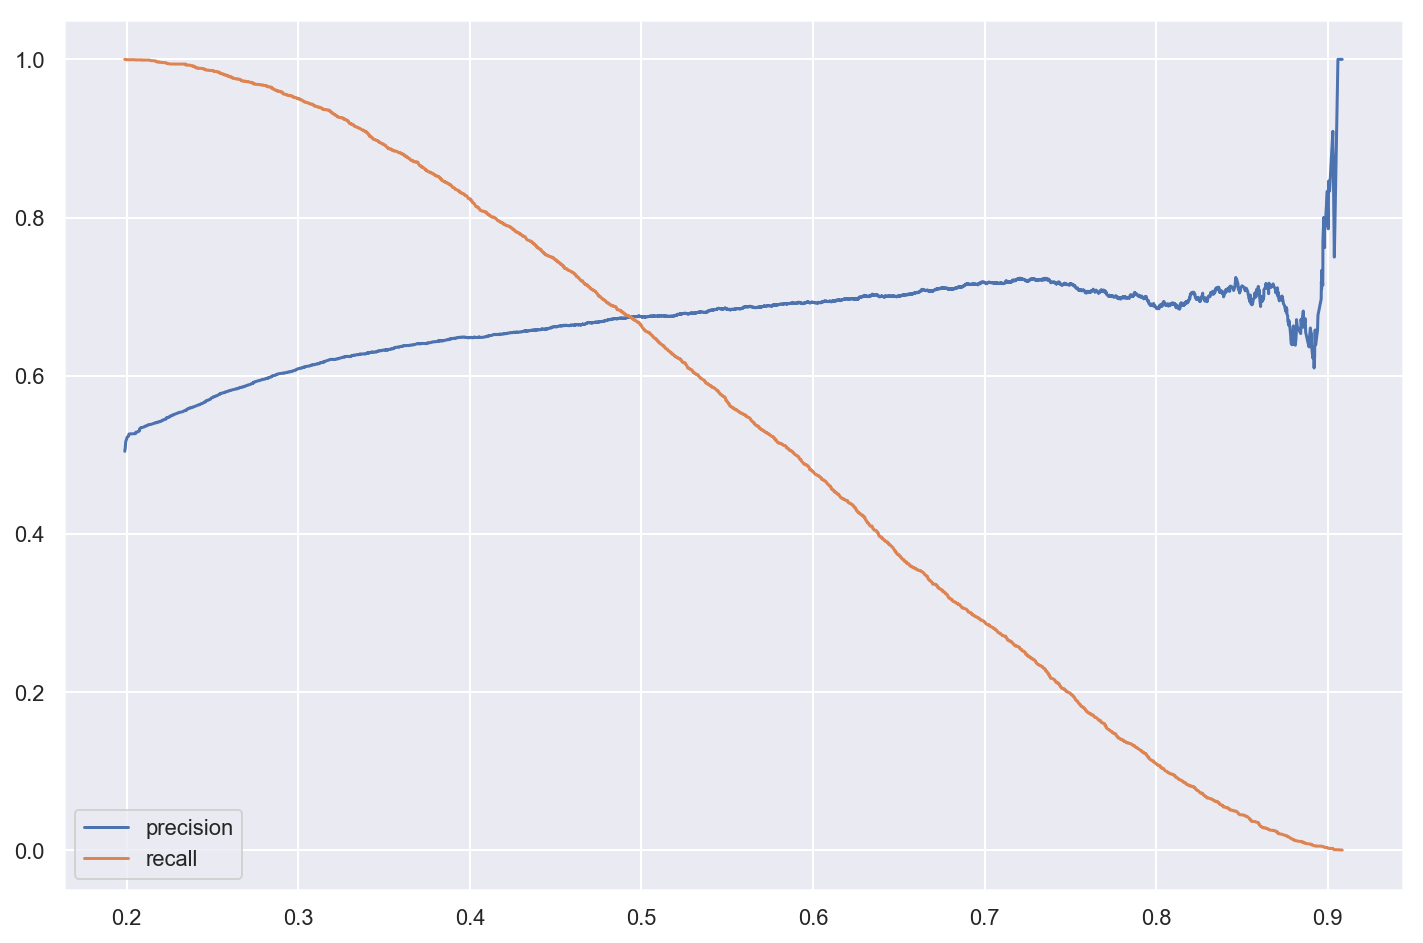

In [56]:
plt.figure(figsize=(12, 8))
plot_pr(y_train_down, y_pred_down)

# Что не успел

1. Распараллелить. Я писал функции так, чтобы в идее их было легко распараллелить. Каждая из них работает отдельно с одной вершиной, не изменяя начальные данные и не затрагивая вычисление других метрик. 
2. Подробнее проанализировать почему для второго круга качество значительно упало. 
3. Сделать подробный EDA, чтобы разобраться как все таки структурно два класса различны и как бороться с дисбалансом классов

# Что помогло разобраться

1. [Predicting missing links via local information](http://image.sciencenet.cn/olddata/kexue.com.cn/upload/blog/file/2009/10/2009102822251329127.pdf) - сравнение всех основных метрик основанных на локальной информации. 
2. [Systematic Biases in Link Prediction: comparing heuristic and graph embedding based methods](https://arxiv.org/pdf/1811.12159.pdf) - здесь прочел о том, как правильно составить обучающую выборку, почему так надо и в чем сложности
3. [An Efficient Link Prediction Technique in Social Networks based on Node Neighborhoods](https://thesai.org/Downloads/Volume9No6/Paper_37-An_Efficient_Link_Prediction_Technique.pdf) - псевдокод для вычисления всех метрик, а также сравнения метрик на датасете фейсбука, который изначально был в задании

Вне зависимости от того, пройду ли я дальше, я бы хотел (если это возможно) получить по этому заданию обратную связь. Мне понравилось это тестовое, оно было сложнее и шире первого. Хотелось бы довести его до конца хотя бы на полном графе. Опять же в ODS мне подсказали, что подсчитать все для 60к вершин вполне реально на нумпае, звучит как челлендж. В общем, у меня осталось множество вопросов, на которые я для себя не успел ответить.

![wow_such_result](img/weird_flex.jpg)